<a href="https://colab.research.google.com/github/JorgeTonatiuh/Tarea_1/blob/main/regresion_lineal_con_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión lineal con PyTorch

Entrena y evalúa un modelo de regresión lineal para el conjunto de datos de calificaciones que
considere los dos atributos de entrada.

Especificaciones:
*   Grafica los datos en 3D.
*   Realiza la definición de la arquitectura usando tanto la interfaz de alto como la de medio nivel.
*   Prueba distintos valores para los hiperparámetros.
*   Realiza una predicción con tu modelo entrenado para la calificación que tendría un alumno si sabemos que estudió durante 12 horas para el examen y en un examen previo obtuvo 3 de calificación.
*   Discute las modificaciones que realizaste y las distintas configuraciones para los hiperparámetros que probaste.










In [1]:
import math
# sistema de archivos
import os
# números aleatorios
import random

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset


## Dataset

In [2]:
# datos
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2022-1/data/califs.csv'
data_dir = '../data'
filepath = os.path.join(data_dir, 'califs.csv')

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

Descargamos los datos.

In [3]:
! mkdir {data_dir}
! wget -nc {URL} -O {filepath}

mkdir: cannot create directory ‘../data’: File exists
File ‘../data/califs.csv’ already there; not retrieving.


Cargamos los datos.

In [4]:
df = pd.read_csv(filepath)
df.head(5)

,prev,horas,calif
0,5.6,8.2,5.1
1,6.7,9.3,5.9
2,5.1,10.0,5.4
3,5.7,10.4,6.5
4,7.1,10.4,6.7


## Grafica los datos en 3D.

Graficamos los datos en 3D para tener una idea más clara de como se encuentran distribuidos.

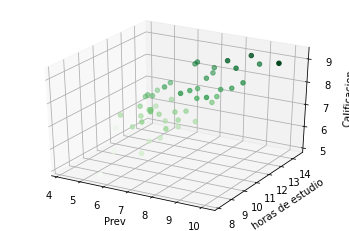

In [5]:
# se obtienen los atributos de entrada y se agrega una dimensión
xdata = np.array(df.iloc[:,0], dtype='float32')[..., np.newaxis]
ydata = np.array(df.iloc[:,1], dtype='float32')[..., np.newaxis]
# se obtiene la salda
zdata = np.array(df.iloc[:,-1], dtype='float32')[..., np.newaxis]
# graficamos
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
ax.set_xlabel('Prev')
ax.set_ylabel('horas de estudio')
ax.set_zlabel('Calificacion');

Proyección horas de estudio vs Calificacion

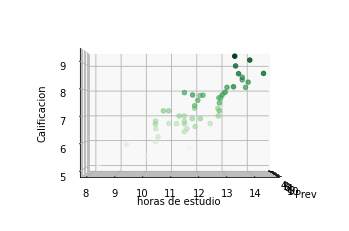

In [6]:
ax.view_init(0, 0)
fig

Proyección Prev vs Calificacion

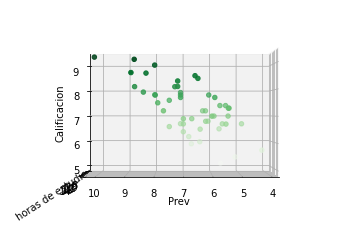

In [7]:
ax.view_init(0, 90)
fig

In [8]:
x_trn = np.array(df.iloc[:,:2], dtype="float32")
y_trn = np.array(df.iloc[:,-1], dtype="float32")[..., np.newaxis]

x_trn = torch.tensor(x_trn)
y_trn = torch.tensor(y_trn)

print(x_trn.shape)
print(y_trn.shape)

torch.Size([50, 2])
torch.Size([50, 1])


## Datos

Conjunto de datos.

Para hacer lotes podemos user la clase TensorDataset.

In [9]:
ds = TensorDataset(x_trn, y_trn)
ds[0]

(tensor([5.6000, 8.2000]), tensor([5.1000]))

Cargador de datos

Para ver el funcionamiento de la tubería de datos imprimimos la forma de cada lote y su primer elemento.

In [10]:
def build_dl(batch_size=16, shuffle=True):
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

# creamos un DataLoader
dl = build_dl()

x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([16, 2]) dtype=torch.float32
y shape=torch.Size([16, 1]) dtype=torch.float32


## Ciclo de entrenamiento

In [11]:
# optimizador
def train(model, dl, epochs=5):

    opt = optim.SGD(model.parameters(), lr=1e-3)

    # historial de pérdida
    loss_hist = []

    # ciclo de entrenamiento
    for epoch in range(epochs):

        # historial
        loss_hist = []
        
        # entrenamiento de una época
        for x, y_true in dl:
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos de pérdida
            loss = F.mse_loss(y_lgts, y_true)
            # vaciamos los gradientes
            opt.zero_grad()
            # retropropagamos
            loss.backward()
            # actulizamos parámetros
            opt.step()

            # guardamos historial de pérdida
            loss_hist.append(loss.item() * 100)
            
        # imprimimos la pérdida de la época
        loss = np.mean(loss_hist)
        print(f'E{epoch:02} loss=[{loss:6.2f}]')

## Realiza la definición de la arquitectura usando tanto la interfaz de alto como la de medio nivel.

Para la definición de la arquitectura se utiliza la clase nn.Sequential en la que se definen las capar y colocamos el Sequential dentro del inicializador.
Posteriormente se implementa la inferencia en el método forward.
De esta manera se aplican ambas APIs tanto de medio como de alto nivel.

In [102]:
#se define la clase RegLin que hereda de torch.nn.Module
class LinRegAltMed(nn.Module):

    #se define el inicializador
    def __init__(self):
        # se llama al inicializador de la clase padre
        super().__init__()
        # definicion de capas        
        self.cls = nn.Sequential(
        nn.Linear(2, 2),
        nn.ReLU(),
        nn.Linear(2, 1),
      )
    
    # método para inferencia
    def forward(self, x):
        x = self.cls(x)
        return x

def build_almed():
    return LinRegAltMed()

build_almed()    

LinRegAltMed(
  (cls): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
)

## Entrenamiento del modelo

In [104]:
set_seed()
dl = build_dl()
model = build_almed()
train(model, dl, 10)

E00 loss=[5240.13]
E01 loss=[2730.91]
E02 loss=[622.67]
E03 loss=[ 47.03]
E04 loss=[ 16.73]
E05 loss=[ 16.66]
E06 loss=[ 15.56]
E07 loss=[ 21.74]
E08 loss=[ 16.46]
E09 loss=[ 15.69]


## Obteniendo parámetros

In [22]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2136,  0.7574],
         [-0.5820, -0.5204]], requires_grad=True), Parameter containing:
 tensor([-0.2413,  0.1896], requires_grad=True), Parameter containing:
 tensor([[0.6947, 0.5607]], requires_grad=True), Parameter containing:
 tensor([0.0584], requires_grad=True)]

## Prueba distintos valores para los hiperparámetros.

## Predicción de un alumno que estudió durante 12 horas para el examen y en un examen previo obtuvo 3 de calificación.

In [34]:
x = torch.tensor([3.0,12.0])
y_pred = model(x)
print(y_pred)

tensor([6.6500], grad_fn=<AddBackward0>)


## Discute las modificaciones que realizaste y las distintas configuraciones para los hiperparámetros que probaste.